In [8]:
RANDOM_STATE = 42

funzione di evaluation predefinita:

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- Results for {model_name} ---")
    print(f"RMSE:\t\t{rmse:.4f}")
    print(f"MAE:\t\t{mae:.4f}")
    print(f"R-squared:\t{r2:.4f}")
    print("-" * 30)

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

Caricamento degli splitting:

In [10]:
import pandas as pd
import os

X_train = pd.read_csv(os.getcwd()+'/processed_data/X_train.csv')
X_val = pd.read_csv(os.getcwd()+'/processed_data/X_val.csv')
X_test = pd.read_csv(os.getcwd()+'/processed_data/X_test.csv')

y_train = pd.read_csv(os.getcwd()+'/processed_data/y_train.csv').values.ravel()
y_val = pd.read_csv(os.getcwd()+'/processed_data/y_val.csv').values.ravel()
y_test = pd.read_csv(os.getcwd()+'/processed_data/y_test.csv').values.ravel()

Convertiamo i nostri DataFrame (che sono array NumPy internamente) in tensori PyTorch.

In [11]:
import torch

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # view(-1, 1) lo rende un tensore colonna

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

Creiamo i DataLoader, che gestiranno i dati in batch durante il training.

In [12]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64 # dimensione dei batch per il training e la validazione

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

architettura:
- hidden layers con un numero decrescente di neuroni
- Funzioni di attivazione ReLU
- Dropout
- MSELoss
- Adam optimizer
- XAVIER initialization
- tutti attributi del modello, per poter gestire tutto tramite di esso tramite il loop di training

In [13]:
from custom_nn import CustomNN

In [22]:
param_grid_nn = {
    'hidden_sizes': [
        [128, 64],
        [256, 128, 64],
        [64, 32, 16],
        [128, 32, 128],
        [256, 256],
        [128, 128, 128],
    ],
    'dropout_rate': [0.2, 0.4]
}

In [23]:
import numpy as np
import copy

NUM_EPOCHS = 200 # numero massimo di epoche di addestramento
VALIDATION_RATE = 1 # evaluation sul validation set ogni 5 epoche
PATIENCE = 10 # numero di epoche da attendere per un miglioramento (meccanismo di early stopping)

best_val_rmse = float('inf')
best_hyperparams = None
best_model_state = None

learning_curves = {} # curve di apprendimento di ogni configurazione

# quindi adottiamo una grid search from scratch
for hidden_config in param_grid_nn['hidden_sizes']:
    for dropout_value in param_grid_nn['dropout_rate']:
        current_hyperparams = {'hidden': hidden_config, 'dropout': dropout_value}
        config_name = f"hidden={hidden_config}_dropout={dropout_value}"
        print(f"\nParams: {current_hyperparams}")

        model = CustomNN(
            input_size=X_train.shape[1],
            hidden_sizes=list(hidden_config),
            dropout_rate=dropout_value
        )

        epochs_no_improve = 0
        min_val_loss = float('inf')
        temp_best_model_state = None

        current_train_losses = []
        current_val_losses = []

        for epoch in range(NUM_EPOCHS):
            model.train()  # model in training mode
            train_loss = 0.0
            for inputs, labels in train_loader: # batch
                model.optimizer.zero_grad() # azzera i gradienti
                outputs = model(inputs) # richiama il metodo forward (forward propagation)
                loss = model.criterion(outputs, labels) # calcolo loss
                loss.backward() # calcolo dei gradienti
                model.optimizer.step() # aggiornamento pesi con i gradienti appena calcolati
                train_loss += loss.item() # loss.item() rappresenta la loss per il singolo batch del loop

            avg_train_loss = train_loss / len(train_loader)
            current_train_losses.append(avg_train_loss)

            # evaluation phase
            if (epoch + 1) % VALIDATION_RATE == 0:
                model.eval() # modello in evaluation mode
                val_loss = 0.0
                with torch.no_grad(): # evita il calcolo del gradient
                    # calcolare evaluation loss
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        loss = model.criterion(outputs, labels)
                        val_loss += loss.item() # loss.item() rappresenta la loss per il singolo batch del loop

                avg_val_loss = val_loss / len(val_loader)
                current_val_losses.append(avg_val_loss)

                # usiamo RMSE per il confronto e la stampa
                current_val_rmse = np.sqrt(avg_val_loss)
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]\tVal. RMSE: {current_val_rmse:.4f}")

                # meccanismo di early stopping (su evaluation loss)
                if avg_val_loss < min_val_loss:
                    min_val_loss = avg_val_loss
                    epochs_no_improve = 0
                    # SALVIAMO I PESI DEL MODELLO
                    temp_best_model_state = copy.deepcopy(model.state_dict())
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= (PATIENCE / VALIDATION_RATE):
                    print(f"Early stopping met at epoch {epoch+1}")
                    break

        learning_curves[config_name] = {'train': current_train_losses, 'val': current_val_losses}

        # confronto con il migliore assoluto (anche qui usiamo RMSE per coerenza)
        if np.sqrt(min_val_loss) < best_val_rmse:
            best_val_rmse = np.sqrt(min_val_loss)
            best_hyperparams = current_hyperparams
            best_model_state = temp_best_model_state


print("\ngrid search completata")
print(f"best params: {best_hyperparams}")
print(f"best RMSE: {best_val_rmse:.4f}")


Params: {'hidden': [128, 64], 'dropout': 0.2}
Epoch [1/200]	Val. RMSE: 1.4567
Epoch [2/200]	Val. RMSE: 1.3620
Epoch [3/200]	Val. RMSE: 1.3114
Epoch [4/200]	Val. RMSE: 1.2760
Epoch [5/200]	Val. RMSE: 1.2428
Epoch [6/200]	Val. RMSE: 1.2128
Epoch [7/200]	Val. RMSE: 1.2361
Epoch [8/200]	Val. RMSE: 1.2168
Epoch [9/200]	Val. RMSE: 1.1959
Epoch [10/200]	Val. RMSE: 1.1815
Epoch [11/200]	Val. RMSE: 1.1841
Epoch [12/200]	Val. RMSE: 1.1597
Epoch [13/200]	Val. RMSE: 1.1501
Epoch [14/200]	Val. RMSE: 1.1862
Epoch [15/200]	Val. RMSE: 1.1548
Epoch [16/200]	Val. RMSE: 1.1527
Epoch [17/200]	Val. RMSE: 1.1593
Epoch [18/200]	Val. RMSE: 1.2031
Epoch [19/200]	Val. RMSE: 1.1804
Epoch [20/200]	Val. RMSE: 1.1936
Epoch [21/200]	Val. RMSE: 1.1720
Epoch [22/200]	Val. RMSE: 1.1522
Epoch [23/200]	Val. RMSE: 1.1475
Epoch [24/200]	Val. RMSE: 1.1377
Epoch [25/200]	Val. RMSE: 1.1322
Epoch [26/200]	Val. RMSE: 1.1381
Epoch [27/200]	Val. RMSE: 1.1457
Epoch [28/200]	Val. RMSE: 1.1504
Epoch [29/200]	Val. RMSE: 1.1546
Epoch

evaluation sul test set del miglior modello

In [30]:
# nuova istanza del modello con gli iperparametri ottimali
best_model_nn = CustomNN(
    input_size=X_train.shape[1],
    hidden_sizes=list(best_hyperparams['hidden']),
    dropout_rate=best_hyperparams['dropout']
)
best_model_nn.load_state_dict(best_model_state)

best_model_nn.eval() # modello in evaluation mode
with torch.no_grad():
    y_test_pred_tensor = best_model_nn(X_test_tensor)

y_test_pred_nn = y_test_pred_tensor.numpy().flatten()

nn_test_metrics = evaluate_model(y_test, y_test_pred_nn, "MLP") # metriche finali sul test set

--- Results for MLP ---
RMSE:		1.1923
MAE:		0.8345
R-squared:	0.1568
------------------------------


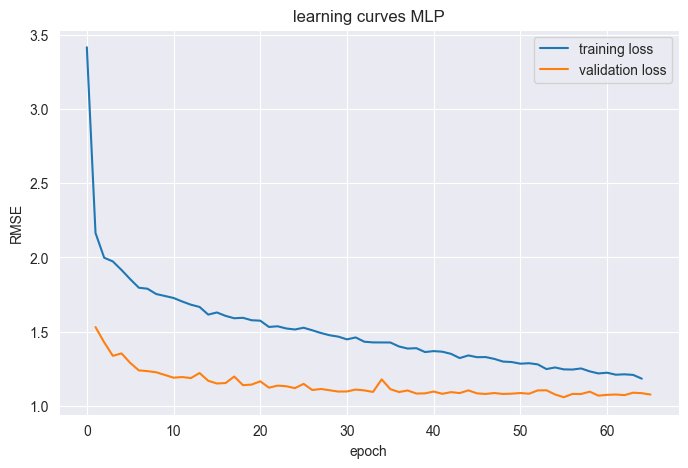

In [31]:
import matplotlib.pyplot as plt

# curve di apprendimento per la migliore configurazione
best_config_name = f"hidden={best_hyperparams['hidden']}_dropout={best_hyperparams['dropout']}"
curves = learning_curves[best_config_name]

plt.figure(figsize=(8, 5))
plt.plot(np.sqrt(curves['train']), label='training loss')
# indici delle epoche per la loss di validazione (potrebbe non essere ogni epoca)
val_epochs = range(VALIDATION_RATE, len(curves['val']) * VALIDATION_RATE + 1, VALIDATION_RATE)
plt.plot(val_epochs, np.sqrt(curves['val']), label='validation loss')
plt.title('learning curves MLP')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

analisi della distribuzione dell'errore anche in questo caso

In [32]:
residui_nn = y_test - y_test_pred_nn
residui_df = pd.DataFrame({'MLP': residui_nn})
residui_stats = residui_df.describe()
residui_stats

,MLP
count,1283.000000
mean,0.021247
std,1.192536
min,-6.326804
25%,-0.509971
50%,0.052453
75%,0.637975
max,5.082608


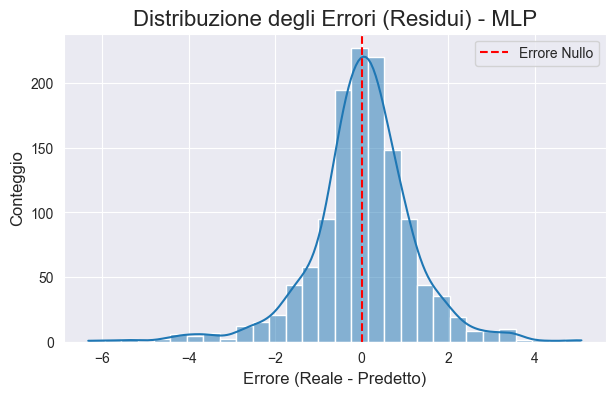

In [37]:
import seaborn as sns

plt.figure(figsize=(7, 4))
sns.histplot(residui_nn, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Errore Nullo')
plt.title('Distribuzione degli Errori (Residui) - MLP', fontsize=16)
plt.xlabel('Errore (Reale - Predetto)', fontsize=12)
plt.ylabel('Conteggio', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


osservazioni:
- distribuzione unimodale e approssimamente simmetrica
- nessun bias significativo
- IQR = 1.148 in linea con gli altri modelli, leggermente più ampio rispetto a RandomForest